In [12]:
import rasterio
import numpy as np
import random
import matplotlib.pyplot as plt

# Define constants
ORIGIN = (38.0718474,46.3440139)  # Example coordinates for Tehran
DESTINATION = (38.05018367,46.36721120)  # Example destination
POPULATION_SIZE = 100
NUM_GENERATIONS = 500
MUTATION_RATE = 0.01
CROSSOVER_RATE = 0.8

In [13]:
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform

# Load raster data
slope_data, slope_transform = load_raster('Data/slope.tif')
population_data, population_transform = load_raster('Data/jamiat.tif')
landuse_data, landuse_transform = load_raster('Data/karbari.tif')
building_age_data, building_age_transform = load_raster('Data/omr_abnie.tif')
road_width_data, road_width_transform = load_raster('Data/arze_mabar1.tif')
risk_data, risk_transform = load_raster('Data/gosal.tif')
floors_data, floors_transform = load_raster('Data/tabaghat.tif')
building_quality_data, building_quality_transform = load_raster('Data/keyfiyat.tif')
fault_data, fault_transform = load_raster('Data/khatar.tif')

In [14]:
def create_random_route(num_points):
    route = [ORIGIN]
    for _ in range(num_points):
        lat = random.uniform(min(ORIGIN[0], DESTINATION[0]), max(ORIGIN[0], DESTINATION[0]))
        lon = random.uniform(min(ORIGIN[1], DESTINATION[1]), max(ORIGIN[1], DESTINATION[1]))
        route.append((lat, lon))
    route.append(DESTINATION)
    return route

In [15]:
def create_initial_population():
    return [create_random_route(random.randint(2, 10)) for _ in range(POPULATION_SIZE)]

In [16]:
def get_raster_value_at_point(lat, lon, raster_data, transform):
    row, col = rasterio.transform.rowcol(transform, lon, lat)
    if 0 <= row < raster_data.shape[0] and 0 <= col < raster_data.shape[1]:
        return raster_data[row, col]
    return 0

In [17]:
def calculate_fitness(route):
    total_value = 0
    for point in route:
        total_value += get_raster_value_at_point(point[0], point[1], slope_data, slope_transform)
        total_value += get_raster_value_at_point(point[0], point[1], risk_data, risk_transform)
        total_value += get_raster_value_at_point(point[0], point[1], population_data, population_transform)
        # Add other raster data checks here
    return 1 / (total_value + 1)  # Higher fitness for lower total value

In [18]:
def select_parents(population, fitnesses):
    return random.choices(population, weights=fitnesses, k=2)

def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, min(len(parent1), len(parent2)) - 1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]
        return child1, child2
    return parent1, parent2

def mutate(route):
    for i in range(1, len(route) - 1):
        if random.random() < MUTATION_RATE:
            route[i] = (random.uniform(min(ORIGIN[0], DESTINATION[0]), max(ORIGIN[0], DESTINATION[0])),
                        random.uniform(min(ORIGIN[1], DESTINATION[1]), max(ORIGIN[1], DESTINATION[1])))
    return route

In [19]:
def evolve_population(population):
    fitnesses = [calculate_fitness(route) for route in population]
    new_population = []
    for _ in range(POPULATION_SIZE // 2):
        parent1, parent2 = select_parents(population, fitnesses)
        child1, child2 = crossover(parent1, parent2)
        new_population.extend([mutate(child1), mutate(child2)])
    return new_population

In [20]:
def main():
    population = create_initial_population()
    best_route = None
    best_fitness = 0

    for generation in range(NUM_GENERATIONS):
        population = evolve_population(population)
        fitnesses = [calculate_fitness(route) for route in population]
        max_fitness = max(fitnesses)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_route = population[fitnesses.index(max_fitness)]
        
        if generation % 100 == 0:
            print(f"Generation {generation}: Best Fitness = {best_fitness}")

    # Plot the best route
    plt.imshow(road_width_data, cmap='gray')
    route_x = [point[1] for point in best_route]
    route_y = [point[0] for point in best_route]
    plt.plot(route_x, route_y, 'r-')
    plt.title("Best Evacuation Route")
    plt.show()

Generation 0: Best Fitness = 0.2548947902970468
Generation 100: Best Fitness = 0.2594596430749848
Generation 200: Best Fitness = 0.2594596430749848
Generation 300: Best Fitness = 0.25946033524055806
Generation 400: Best Fitness = 0.25946033524055806


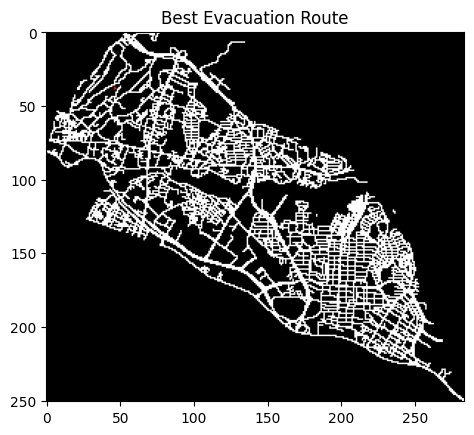

In [21]:
if __name__ == "__main__":
    main()